In [1]:
# %load ../startup.py
import os,sys
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('LIB')
if not os.environ.get('LIB') in sys.path: 
    sys.path.insert(0,os.environ.get('LIB'))

DAT_DIR = os.environ.get('DAT_DIR')    

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 
from matplotlib import gridspec
from scipy.interpolate import splev, splrep
import xlwt
import seaborn as sns
from scipy import stats
import rpy2.robjects.packages as rpackages
import seaborn as sns
from statsmodels import robust


from heprnhci.db.mongo import *


from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>")) # increase jupyter screen width to 100%
pd.options.display.max_colwidth = 500
pd.set_option('display.precision',2)

HCI=openMongo(db=os.environ.get('MONGO_HCIDB'),host=os.environ.get('MONGO_HOST'),auth=False)


# Goal

Calculate chemical effects on all endpoints

# Calculate FCs

In [20]:
from hci.fc import *
HCI.heprn_ch.drop()
for plate_id in HCI.heprn_raw.distinct('plate_id'):
    print plate_id
    calcChanges(plate_id,dbc_raw=HCI.heprn_raw,
                ft_name='FA0',
                dbc_ch=HCI.heprn_ch)


HCS-UC-W73_160624150001
HCS-UC-W73_160624160002
HCS-UC-W73_160625080001
HCS-UC-W73_160625080002
HCS-UC-W73_160628150001
HCS-UC-W73_160629070001
HCS-UC-W73_160712160001
HCS-UC-W73_160712170001
HCS-UC-W73_160712170002
HCS-UC-W73_160712180001
HCS-UC-W73_160713080001
HCS-UC-W73_160713080002
HCS-UC-W73_160713090001
HCS-UC-W73_160713090002
HCS-UC-W73_160713090003
HCS-UC-W73_160713100001
HCS-UC-W73_160713100002
HCS-UC-W73_160713100003
HCS-UC-W73_160713110001
HCS-UC-W73_160713110002
HCS-UC-W73_160713110003
HCS-UC-W73_160713120001
HCS-UC-W73_160713170001
HCS-UC-W73_160713170002
HCS-UC-W73_160714170001
HCS-UC-W73_160720080001


/home/ishah/ipynb/pb/heprn/lib/hci/fc.py:37: RuntimeWarning: invalid value encountered in double_scalars
  def cv(X): return np.std(X)/np.mean(X)
/home/ishah/ipynb/pb/heprn/lib/hci/fc.py:77: RuntimeWarning: divide by zero encountered in log2
  CH.loc[:,'l2fc_ctrl']=np.log2(CH.raw_mean/CH.ctrl_n_mean)
/home/ishah/ipynb/pb/heprn/lib/hci/fc.py:79: RuntimeWarning: divide by zero encountered in log2
  CH.loc[:,'l2fc_plt'] =np.log2(CH.raw_mean/CH.plt_mean)


HCS-UC-W73_160720160001
HCS-UC-W73_160720170001
HCS-UC-W73_160721130002
HCS-UC-W73_160721160001
HCS-US-W71_160624150001
HCS-US-W71_160624190001
HCS-US-W71_160625080002
HCS-US-W71_160628170001
HCS-US-W71_160629070001
HCS-US-W71_160706080001
HCS-US-W71_160706090001
HCS-US-W71_160706090002
HCS-US-W71_160706090003
HCS-US-W71_160706100001
HCS-US-W71_160706100002
HCS-US-W71_160712160001
HCS-US-W71_160712170001
HCS-US-W71_160712180001
HCS-US-W71_160712190001
HCS-US-W71_160712190002
HCS-US-W71_160712200001
HCS-US-W71_160713140001
HCS-US-W71_160714160001
HCS-US-W71_160714170002
HCS-US-W71_160714170003
HCS-US-W71_160714170004
HCS-US-W71_160714180001
HCS-US-W71_160719130001
HCS-US-W71_160719140001
HCS-US-W71_160719150001
HCS-US-W71_160720060001
HCS-US-W71_160720060002
HCS-US-W71_160720060003
HCS-US-W71_160720070001
HCS-US-W71_160720070002
HCS-US-W71_160720070003
HCS-US-W71_160720080001
HCS-US-W71_160720080002
HCS-US-W71_160720090001
HCS-US-W71_160720130001
HCS-US-W71_160720130002
HCS-US-W71_16072

# Evaluate FCs

In [ ]:
RES=[]
for P in HCI.heprn_ch.find(dict(chemicals='Acetaminophen')):
    FC = pd.DataFrame(P['chem_ch'])
    print '>', P['plate_id'],FC.shape[0],FC.query("name=='Acetaminophen'").shape[0]
    print ' ', FC.query("name=='Acetaminophen'").FA0.unique()
    RES.append(FC.query("name=='Acetaminophen'"))
X = pd.concat(RES).pivot_table(index=['name','timeh','conc'],columns='FA0',values='l2fc_ctrl')

In [88]:
Features=pd.DataFrame(list(HCI.hci_feats.find({},dict(_id=0))))
Features

,FA0,FA1,FN0,FN1
0,DT,DT,DNATexture,DNATexture
1,MF,MF,MitoFxnI,MitoFxnI
2,LM,LM,LysosomalMass,LysosomalMass
3,NS1,NS,NuclearSize1,NuclearSize
4,CN1,CN,CellNumber1,CellNumber
5,ES,ES,ERStress,ERStress
6,Ap,Ap,Apoptosis,Apoptosis
7,NS2,NS,NuclearSize2,NuclearSize
8,CN2,CN,CellNumber2,CellNumber
9,St,St,Steatosis,Steatosis


In [96]:
X = pd.concat(map(pd.DataFrame,[i.get('chem_ch') for i in HCI.heprn_ch.find({},{'_id':0,'chem_ch':{'$elemMatch':{'name':'1,1-Dimethylhydrazine'}}}) if i.has_key('chem_ch')]))
X1= X.merge(Features,on='FA0')
#HCI.heprn_ch.find_one().keys()
X.FA0.unique(),X1.FA0.unique()

(array([u'DT', u'MF', u'Ap', u'CN2', u'LM'], dtype=object),
 array([u'DT', u'MF', u'Ap', u'CN2', u'LM'], dtype=object))

In [101]:
[i for i in X.columns if i.startswith('pv')]

[u'pv_n_ctrl', u'pv_plt']

In [112]:
from hci.fc import *

chem='Alachlor'
va ='l2fc_ctrl'
ft  ='FA1'
FC = getChemFC(chem,feat=ft,val=va,fc_key='chem_ch',
               pivot=True,dbc_fc=HCI.heprn_ch,what='cr',
               dbc_ft=HCI.hci_feats)
FC

FA1                          Ap        CN        DT        ES    LM        MF  \
name     timeh conc                                                             
Alachlor 1     0.20    6.65e-03 -2.62e-01 -1.33e-01  4.23e-02 -0.02  1.53e-03   
               0.39   -1.18e-01  2.16e-01 -1.18e-01 -8.02e-03 -0.15  1.10e-02   
               0.78    1.10e-01  2.36e-01 -1.09e-01 -1.44e-02 -0.28  2.90e-03   
               1.56   -6.95e-02  1.15e-01 -2.07e-01 -5.73e-03 -0.10 -2.38e-02   
               3.12    5.70e-01  3.31e-01 -6.86e-02  3.41e-01  0.14 -4.27e-03   
               6.25    2.31e-01  1.42e-01  1.48e-01  1.63e-01  0.21 -8.36e-02   
               12.50   2.57e-02  2.22e-01 -2.17e-01 -4.43e-02 -0.17 -1.51e-02   
               25.00  -1.99e-01  1.02e-01  2.89e-01 -3.30e-01 -0.16 -2.22e-02   
               50.00  -3.39e-01  2.18e-01  3.96e-01 -6.31e-01 -0.86 -4.22e-01   
               100.00  1.58e-01  2.48e-01  8.14e-01 -5.93e-01 -0.97 -6.12e+00   
         3     0.20    1.66e-02  1.26e-01 -3.97e-02 -6.55e-02 -0.07 -6.16e-03   
               0.39   -1.20e-01  4.23e-02 -1.45e-02  9.51e-02 -0.05  1.27e-02   
               0.78    3.36e-01  9.94e-02  3.00e-03  2.57e-01 -0.20  1.25e-02   
               1.56   -4.53e-02  2.09e-02 -1.00e-02 -7.24e-02  0.16  8.07e-03   
               3.12    5.91e-01  1.33e-01  3.04e-03  3.94e-01  0.24 -2.07e-02   
               6.25    2.88e-01 -3.89e-04  7.27e-02  2.89e-01 -0.04 -5.53e-02   
               12.50   2.74e-01  7.36e-03  1.59e-01  1.81e-01  0.17  2.39e-02   
               25.00  -4.36e-01 -8.31e-03  1.03e+00 -1.09e+00 -0.73 -2.96e+00   
               50.00  -2.65e-01 -2.23e-02  1.05e+00 -9.34e-01 -0.79 -6.64e+00   
               100.00  1.79e-01 -6.07e-02  1.06e+00 -4.74e-01 -0.76 -7.89e+00   
         6     0.20   -7.56e-02  7.35e-02 -1.55e-01  5.41e-03  0.02  6.66e-02   
               0.39   -2.99e-02  5.88e-03 -1.81e-02  9.29e-02  0.08 -1.17e-01   
               0.78    7.89e-01 -2.43e-02  1.82e-02  4.25e-01  0.03  4.39e-02   
               1.56    2.00e-01  1.63e-02  1.79e-02  1.30e-01  0.04  4.78e-02   
               3.12    8.13e-01  2.95e-02  1.79e-01  6.18e-01  0.28  4.39e-02   
               6.25    1.69e-01 -7.64e-02  1.18e-01  1.06e-01  0.10  2.34e-02   
               12.50   5.70e-02 -7.16e-02  6.58e-01 -6.66e-02 -0.04  2.97e-02   
               25.00  -6.01e-01 -7.72e-02  1.57e+00 -1.17e+00 -1.06  1.93e-02   
               50.00   5.23e-01 -5.88e-02  1.64e+00 -3.39e-01 -0.87  1.56e-02   
               100.00  6.69e-01  1.98e-03  1.68e+00 -1.47e-01 -0.87 -1.93e-01   
         24    0.20    4.03e-01  3.79e-02  5.41e-02  9.52e-02  0.24  1.61e-02   
               0.39    4.25e-01 -2.00e-02  2.57e-02  3.30e-01  0.04  4.94e-02   
               0.78    2.14e-01 -4.68e-02 -5.75e-02 -2.23e-02 -0.01  2.08e-02   
               1.56    4.00e-01  3.37e-02  1.62e-02  1.79e-01  0.21  4.96e-02   
               3.12    1.43e-01  4.77e-02  6.27e-02  2.11e-02  0.23  3.23e-02   
               6.25    5.21e-01  1.71e-02  1.32e-01  2.11e-01  0.26  4.86e-02   
               12.50   6.22e-01  4.06e-02  3.73e-02  2.45e-02  0.14  2.37e-02   
               25.00   3.79e-01  2.00e-01 -3.41e-02 -4.13e-02  0.22  7.06e-02   
               50.00   1.20e+00 -7.12e-02  1.74e+00  6.02e-01  0.14  2.38e-03   
               100.00  1.70e+00  8.75e-03  2.08e+00  8.13e-01 -0.36 -9.17e+00   
         48    0.20    3.31e-01 -8.90e-02  2.27e-01  5.44e-01  0.14  6.20e-02   
               0.39    6.44e-02 -5.81e-02  2.41e-01  3.68e-01  0.05  6.54e-02   
               0.78    4.44e-01 -5.83e-02  1.08e-01  4.23e-01 -0.04  4.28e-02   
               1.56    4.61e-01 -1.65e-01  5.94e-03  3.03e-01  0.07  5.42e-02   
               3.12    2.53e-01 -6.52e-02  2.05e-01  3.19e-01  0.37  4.33e-02   
               6.25    1.08e-01 -1.33e-01  7.19e-02 -2.22e-03  0.09  8.53e-03   
               12.50   1.12e+00 -1.23e-02 -8.07e-02  4.85e-01  0.13  1.08e-02   
               25.00   6.35e-01

# Visualize FCs

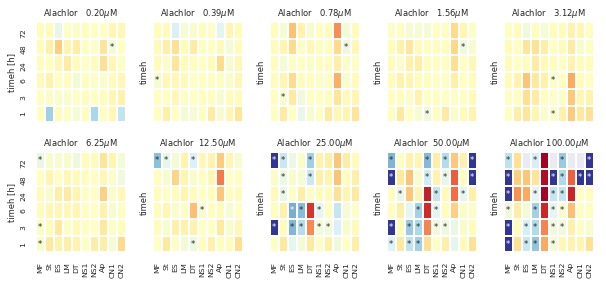

In [113]:
from hci.fc import *

chem='Alachlor'
va ='l2fc_ctrl'
ft  ='FA0'

fig = vizChemTraj(chem,feat=ft,val=va,pv=0.1,dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats,fc_key='chem_ch')


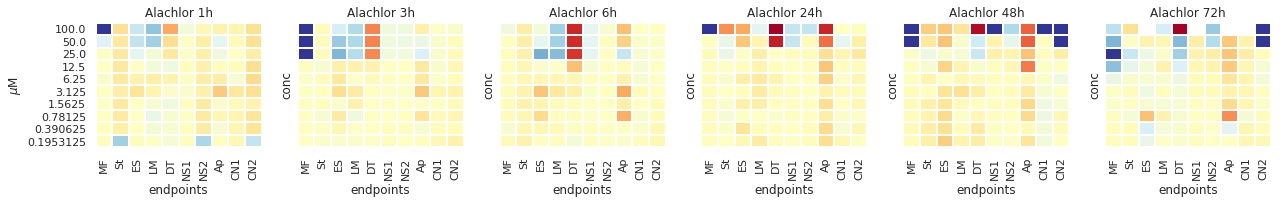

In [12]:
from hci.fc import *
sns.set(style='white')
chem='Alachlor'
va ='l2fc_ctrl'
ft  ='FA0'

fig = vizChemCR(chem,feat=ft,val=va,pv=None,dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)


In [9]:
FDIR=FIG_DIR+'cr'
import os
os.mkdir(FDIR)

In [10]:
import re

2-Butoxyethanol
3'-Azido-3'-deoxythymidine
Acetaminophen
Bronopol
Bupivacaine
Butachlor
Carbonyl cyanide chlorophenylhydrazone
Clodinafop-propargyl
Cyproconazole
Dichlobenil
Dimethyl sulfoxide
Dithiopyr
Furfural
Isoxaben
MCPA
Nimesulide
Pentachloronitrobenzene
Propyzamide
Simazine
Tamoxifen
Triflumizole
4-Nitroaniline
Bensulide
Bentazone
Chloridazon
Coumarin
Ethofumesate
Fenarimol
Fludioxonil
Flusilazole
Metolachlor
Oxadiazon
Pioglitazone hydrochloride
S-Bioallethrin
Triclosan
Triticonazole
Zoxamide
Alachlor
Allethrin
Boscalid
Cariporide mesylate
Clofibrate
Cyprodinil
Etoxazole
Fosthiazate
Hexaconazole
Imidacloprid
Lindane
N,N-Dimethylformamide
Propamocarb hydrochloride
Pyrimethanil
Pyrithiobac-sodium
Triadimefon
1-Chloro-4-nitrobenzene
Ametryn
CJ-013790
Captan
Diphenylamine
Endothal
Fenbuconazole
Fenthion
Folpet
Imazalil
Isazofos
Isoxaflutole
Mercuric chloride
Methyl parathion
Resmethrin
Rimsulfuron
2,4-Dichlorophenoxyacetic acid
Acetochlor
Aldrin
Chlorpropham
Dimethenamid
Lactofen
Sp

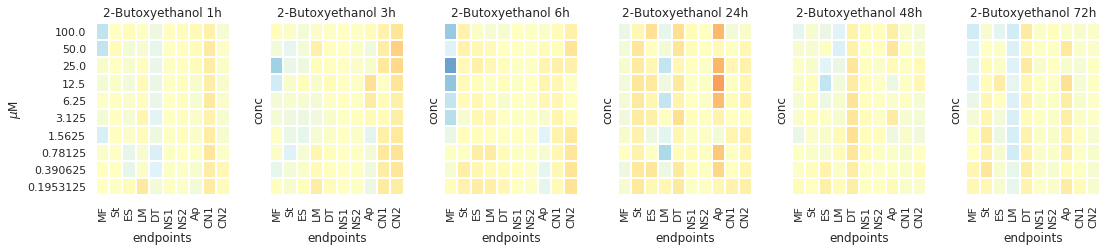

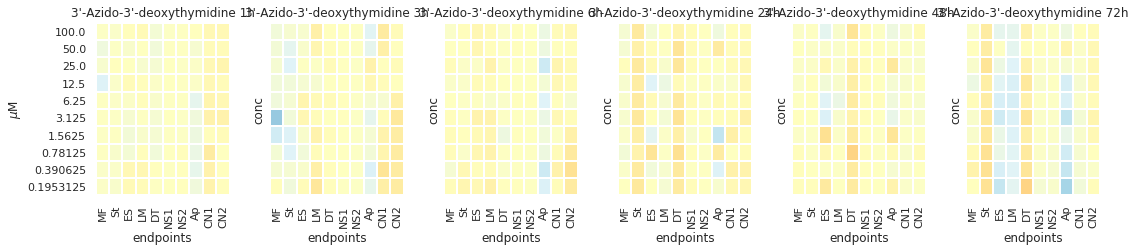

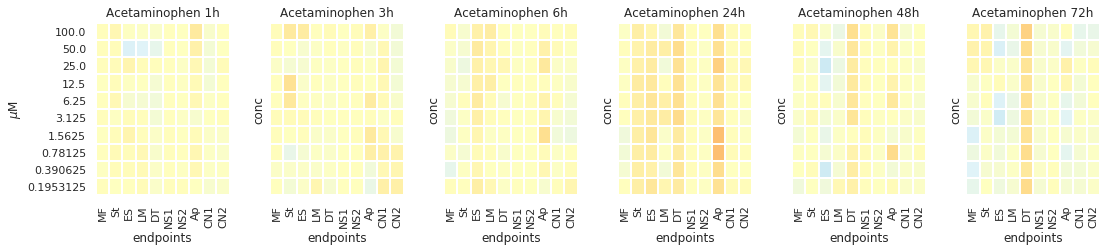

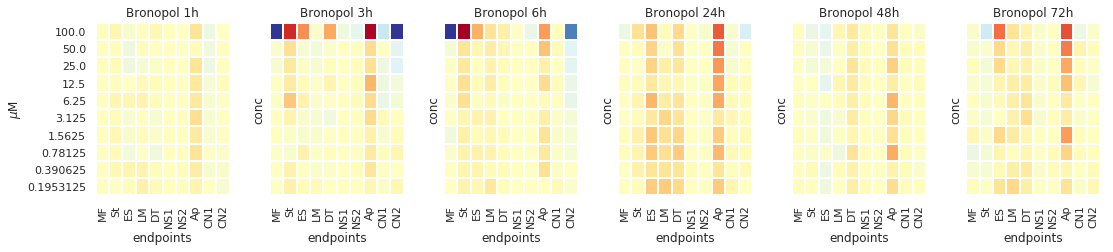

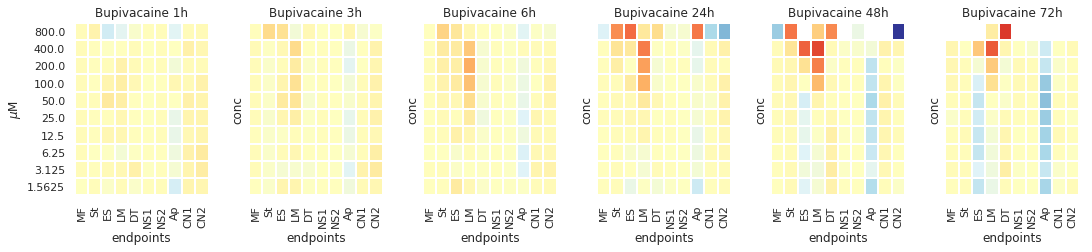

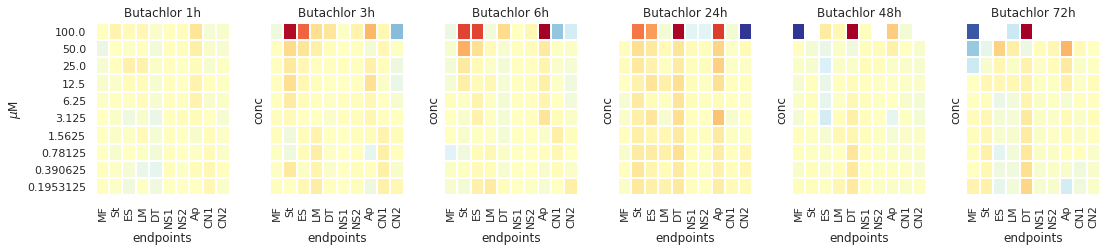

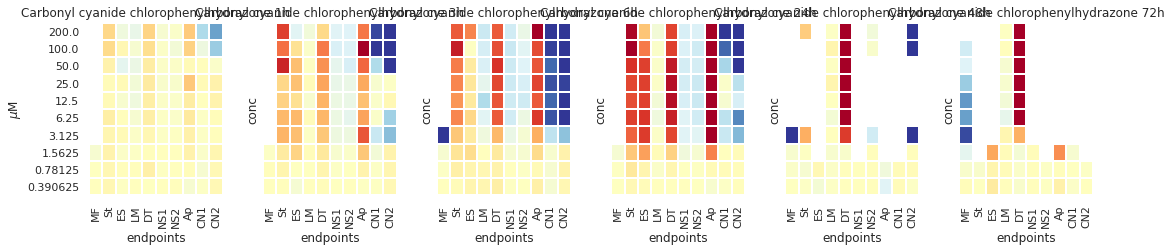

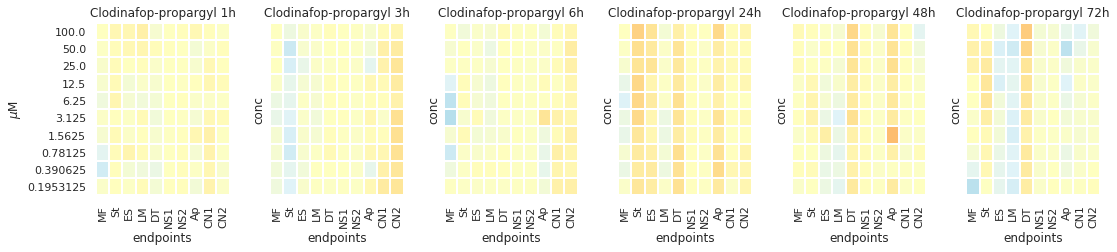

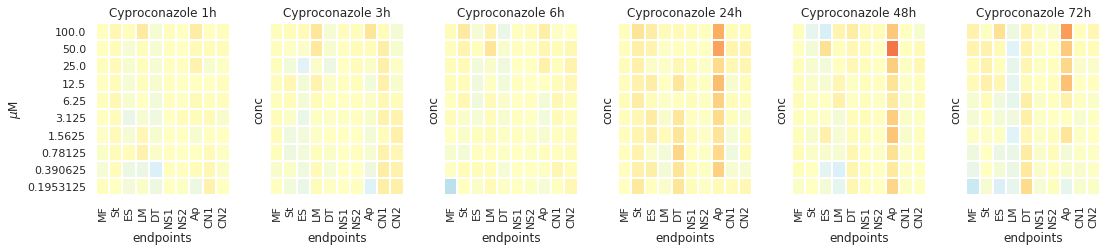

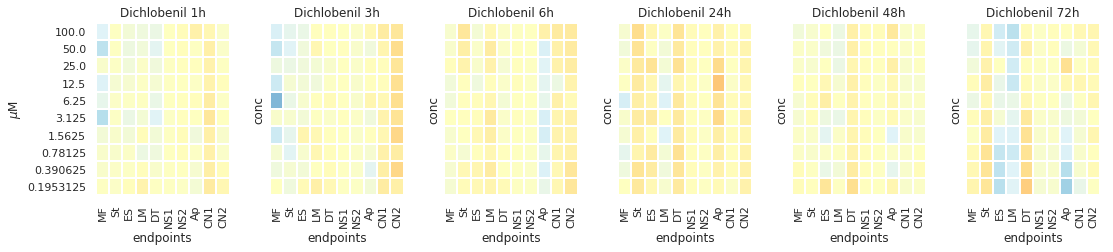

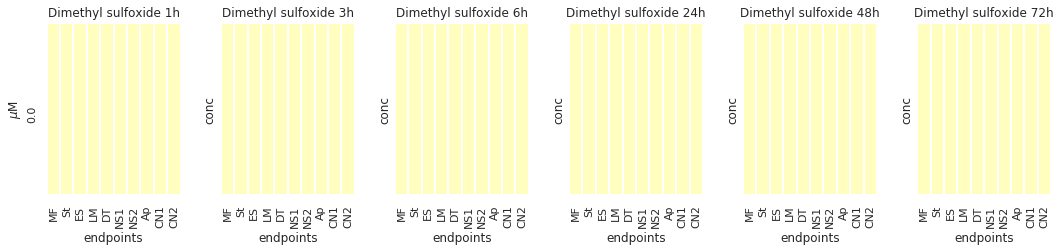

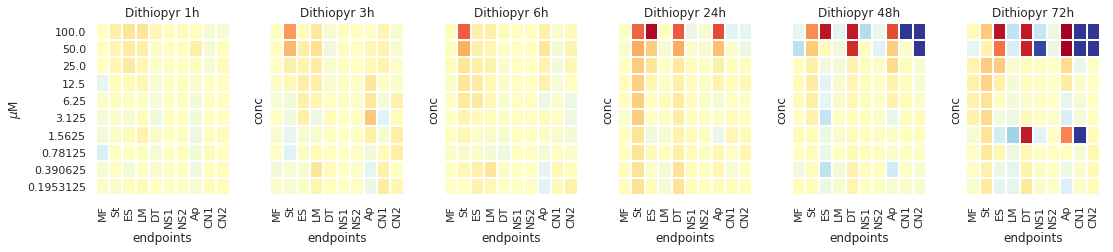

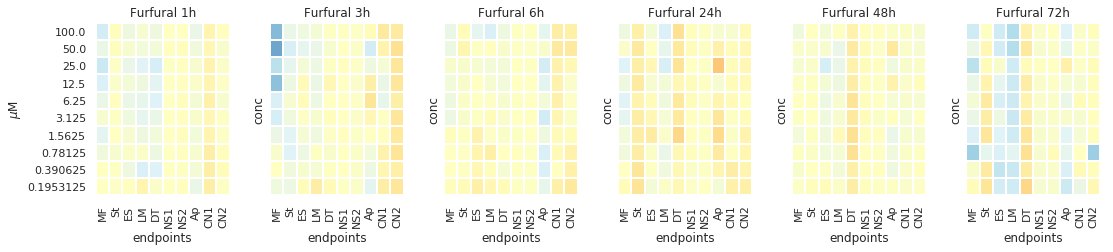

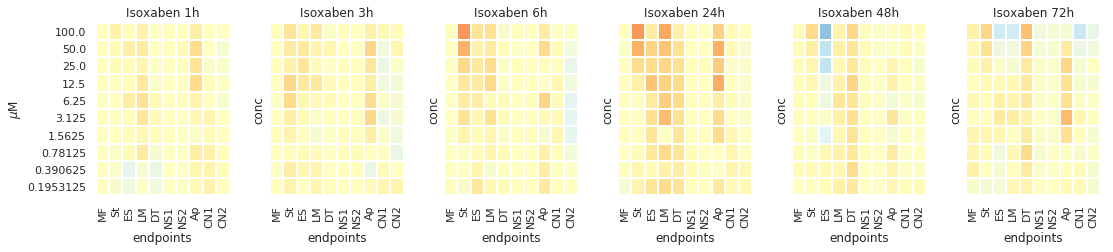

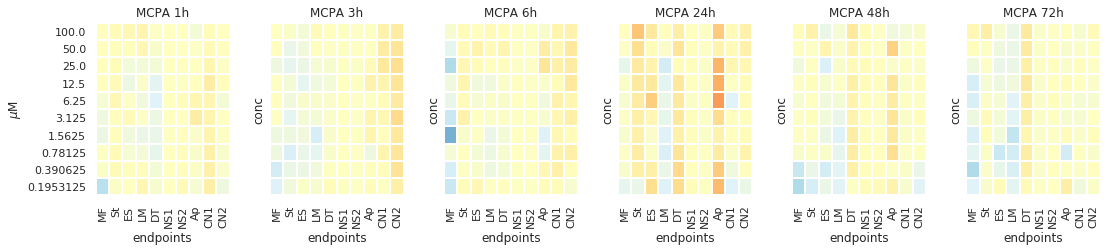

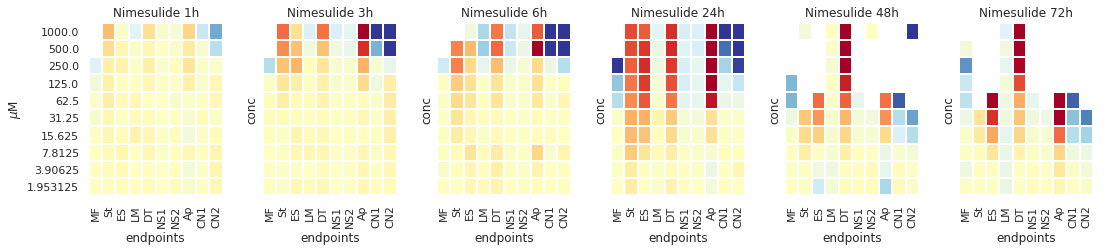

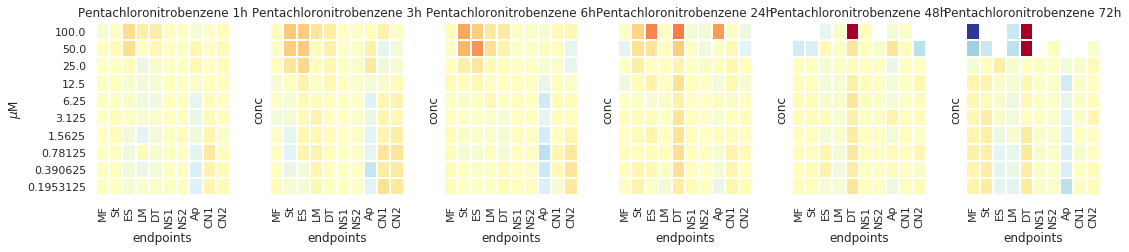

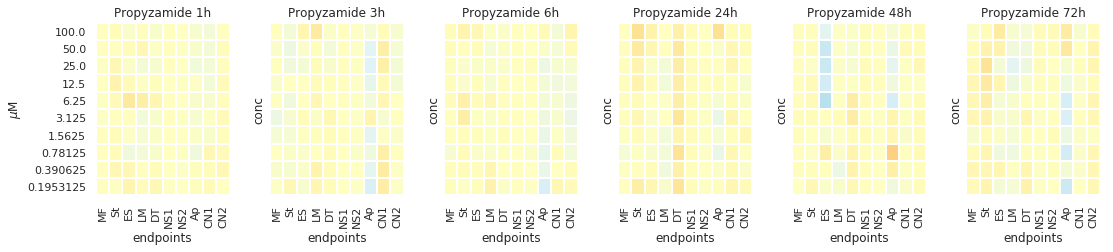

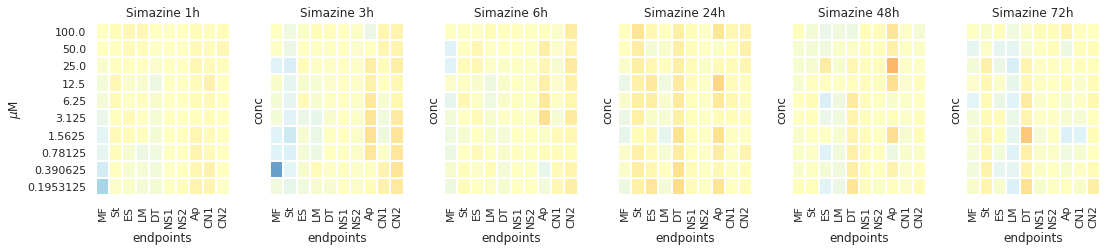

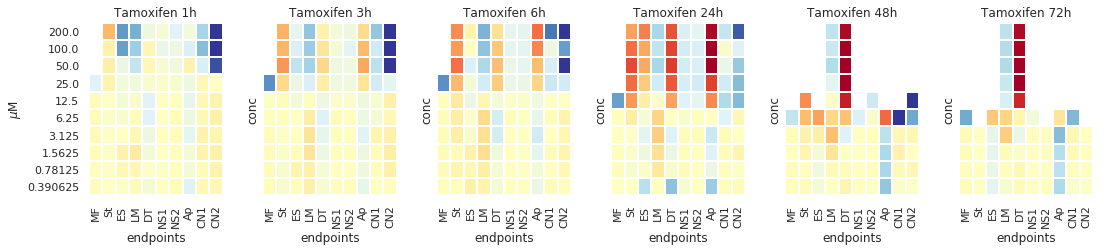

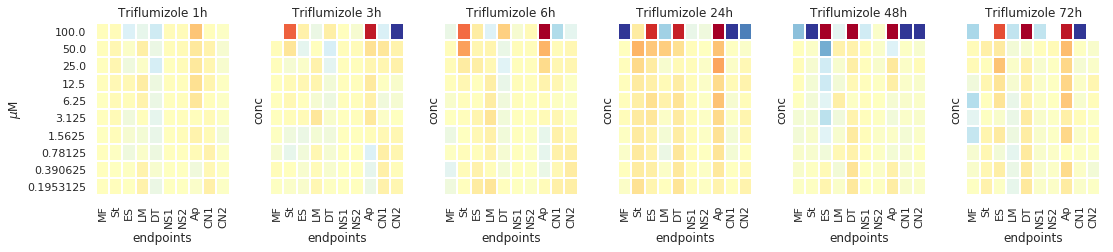

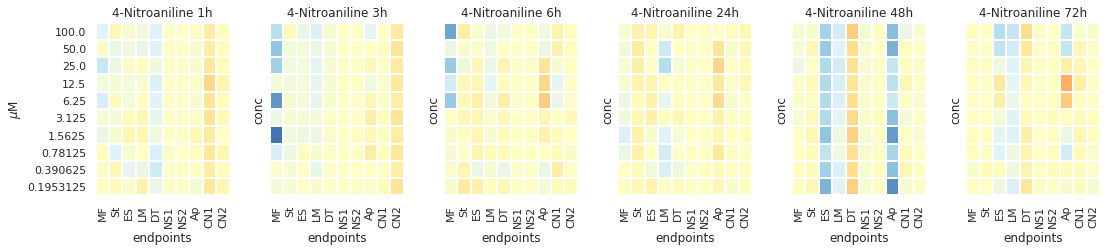

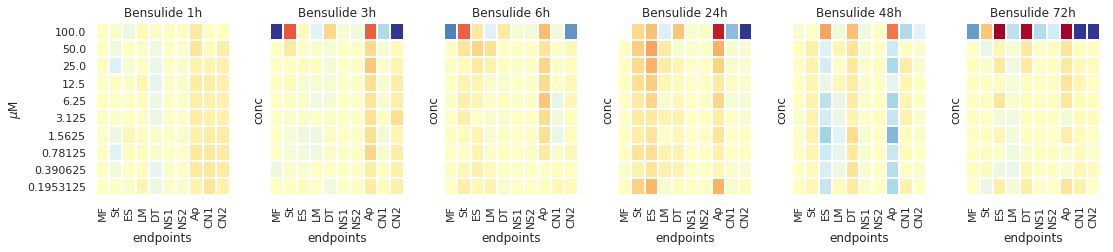

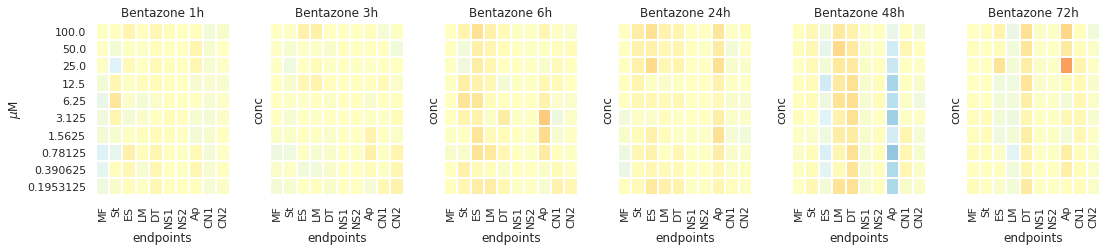

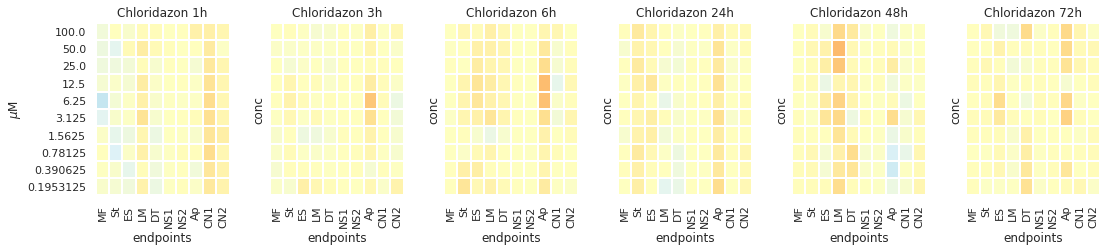

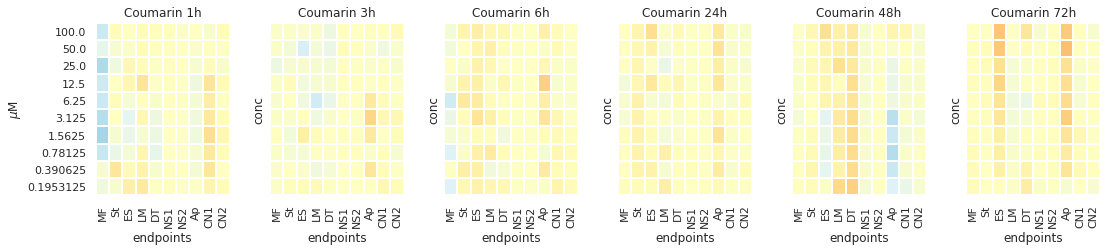

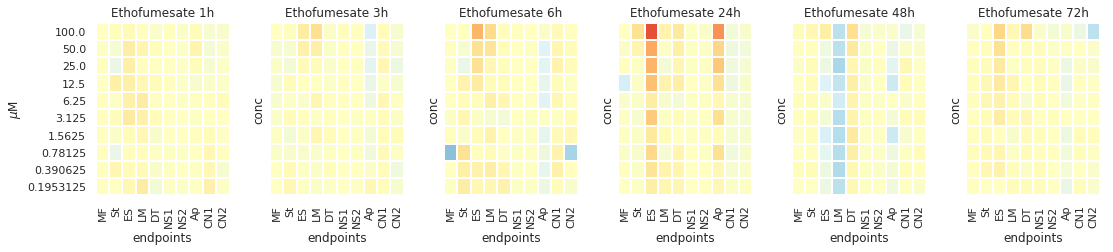

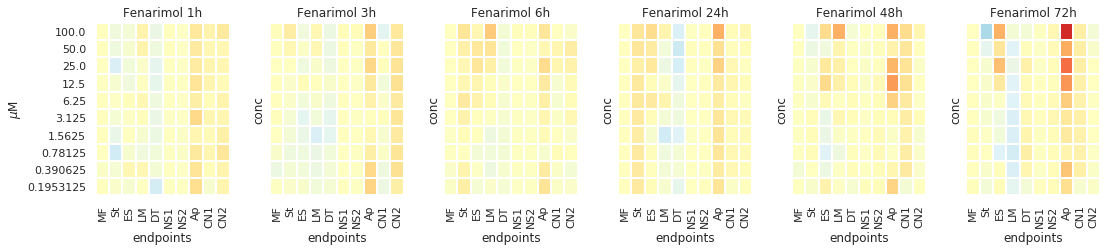

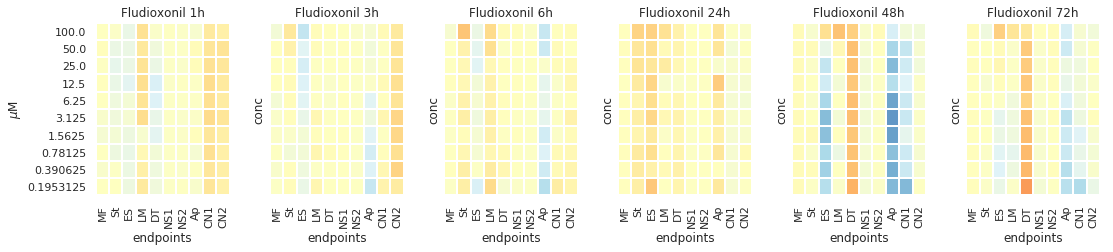

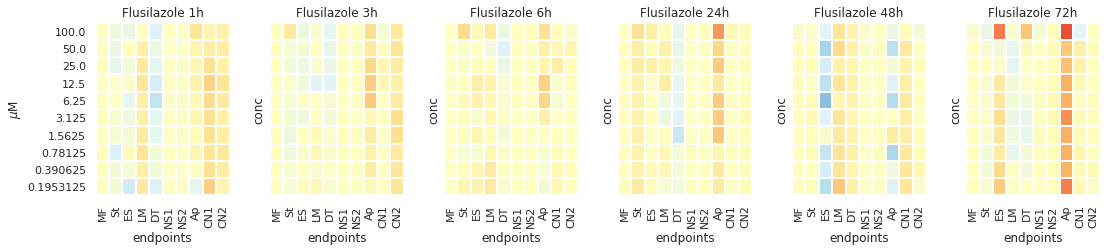

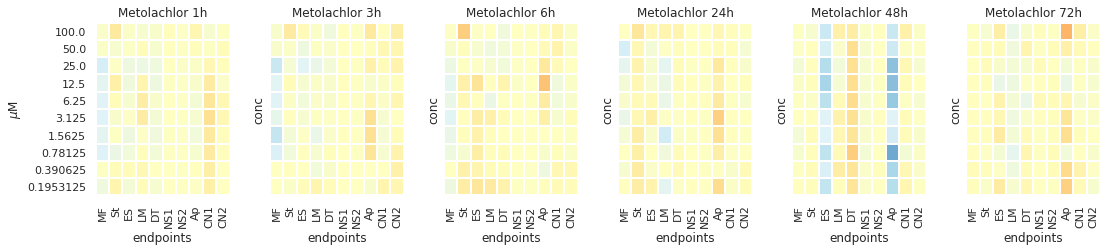

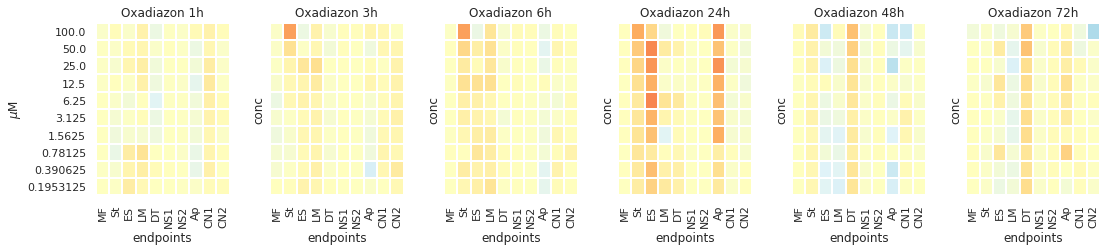

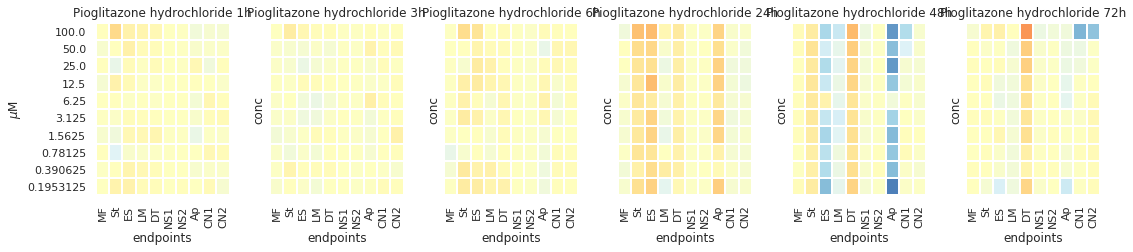

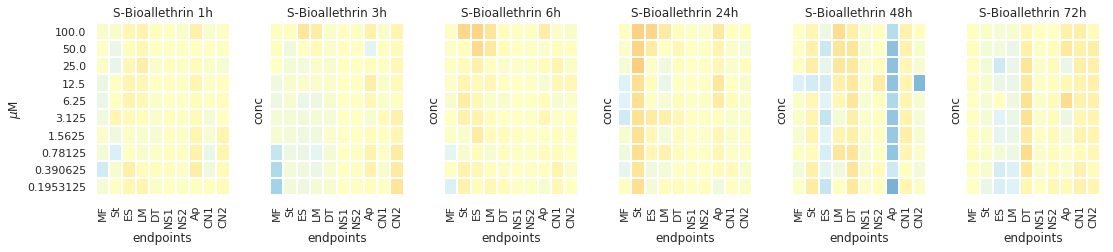

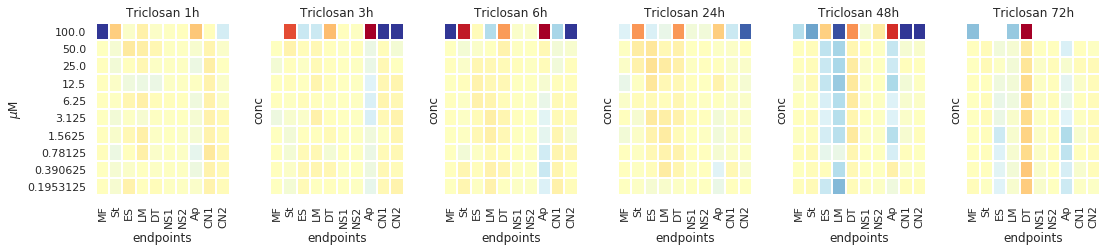

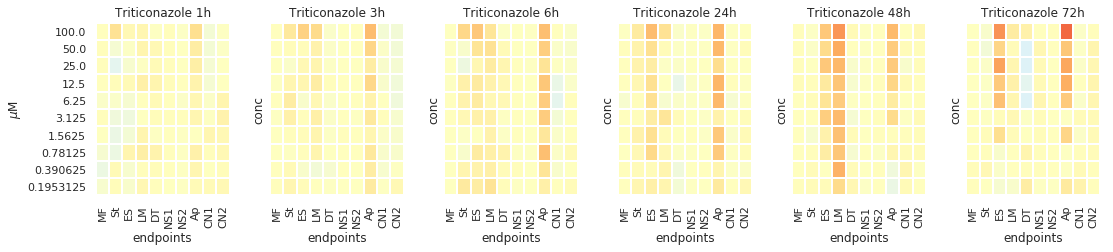

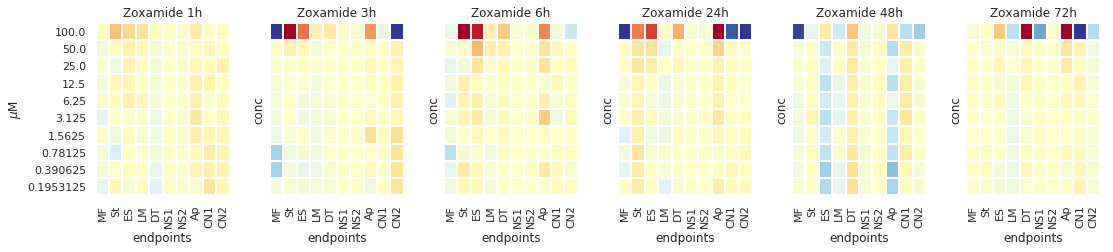

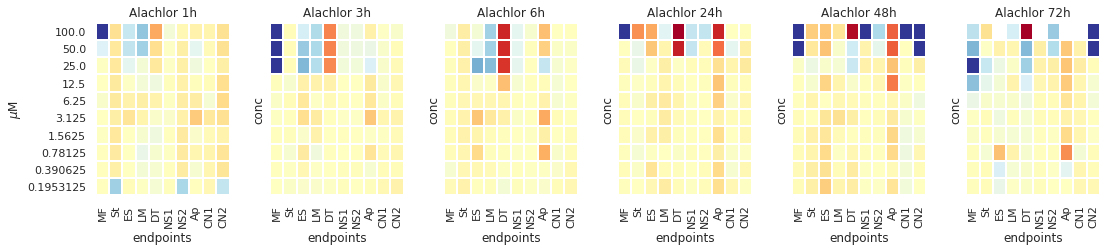

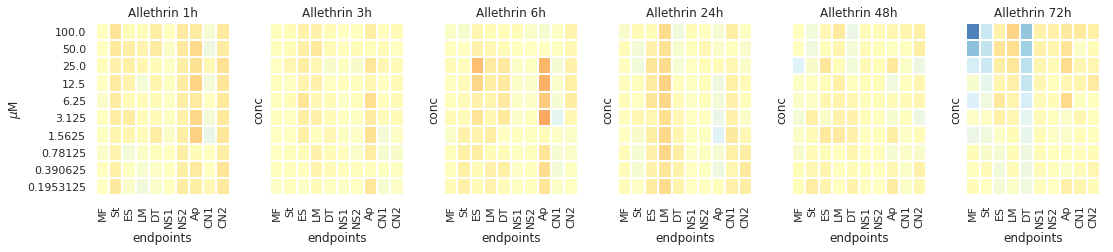

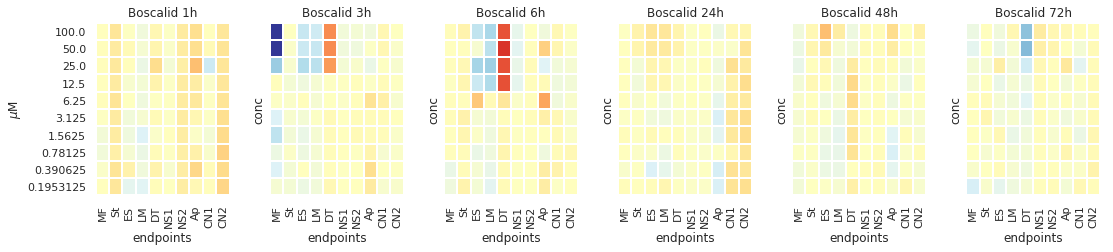

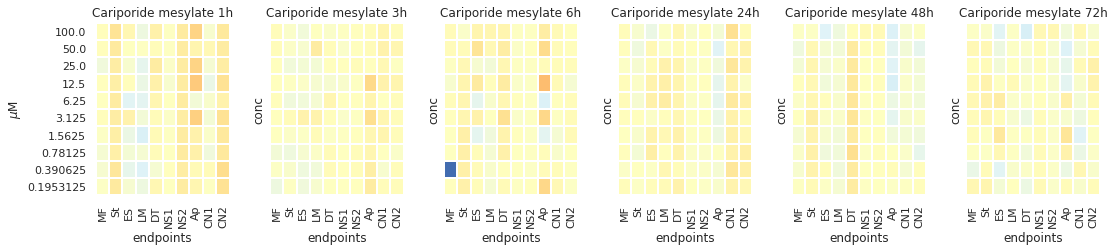

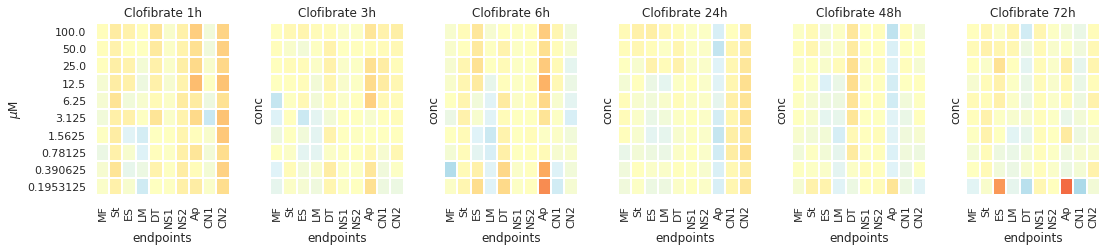

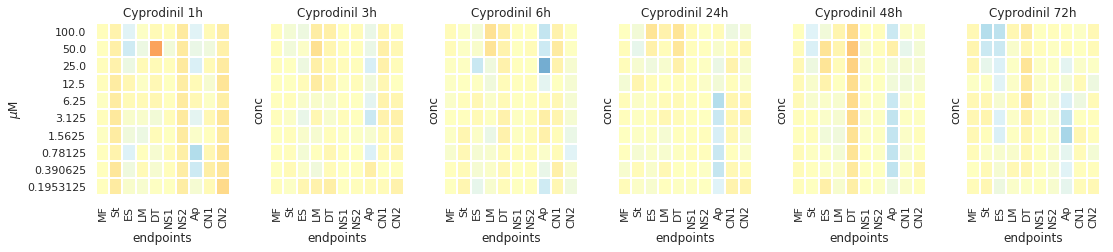

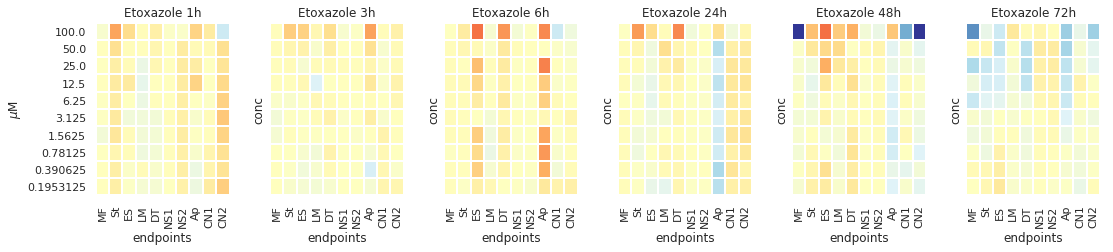

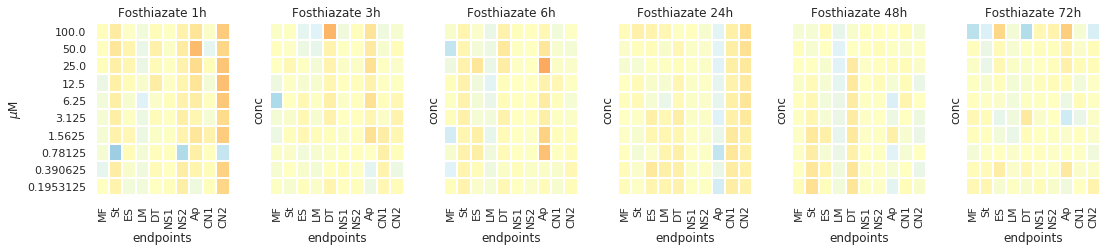

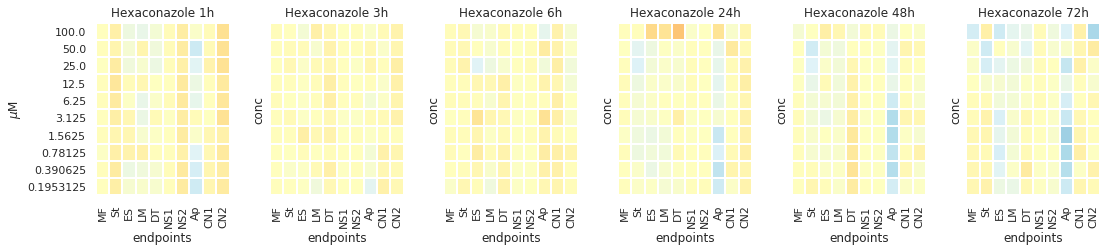

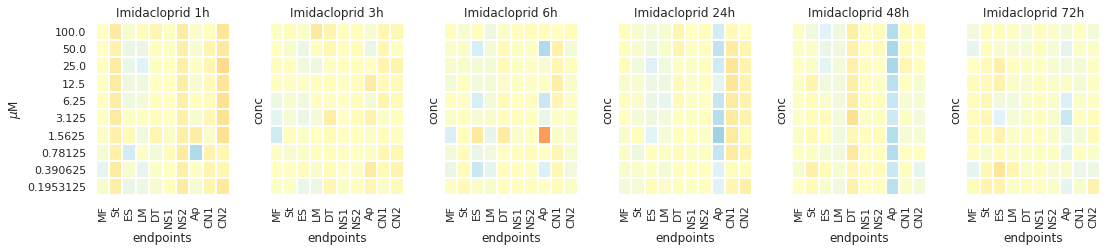

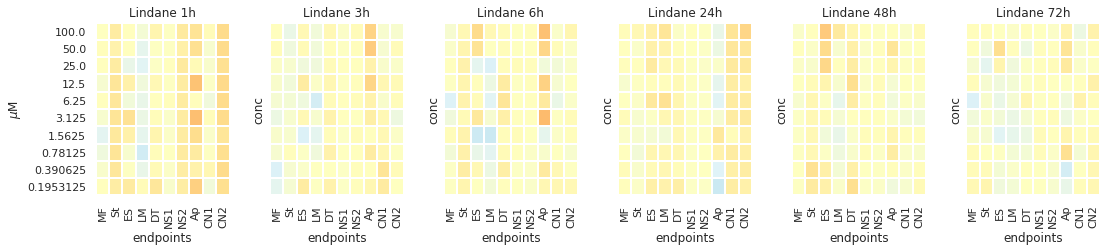

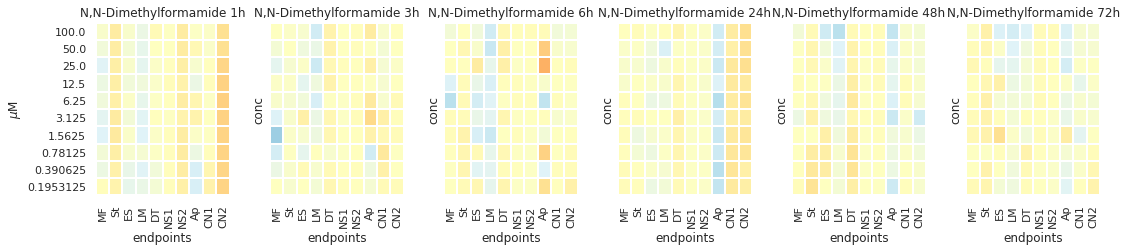

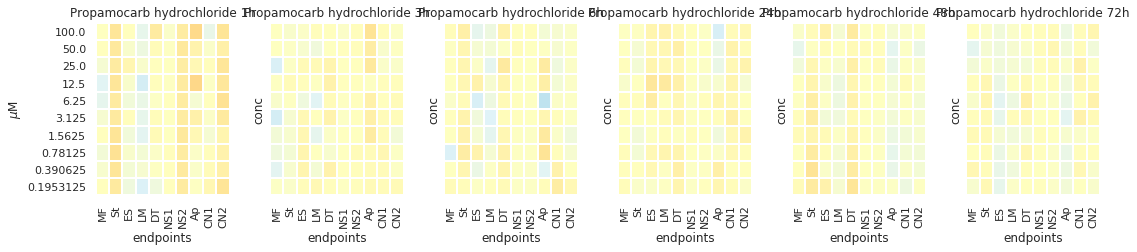

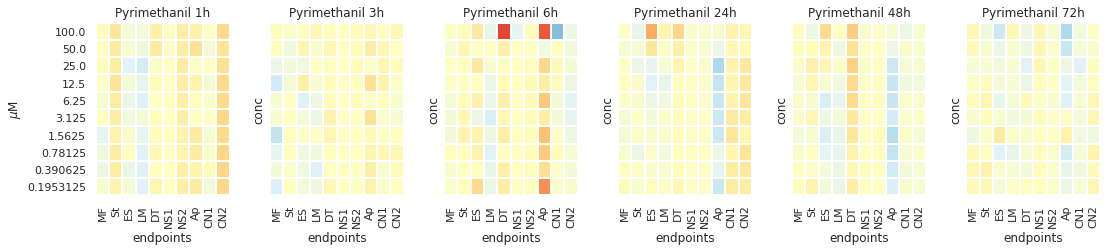

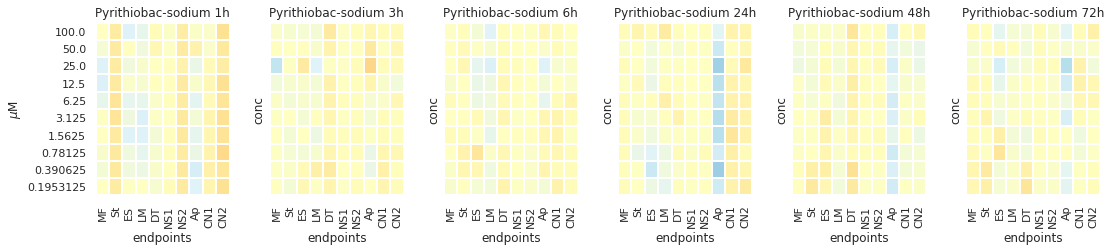

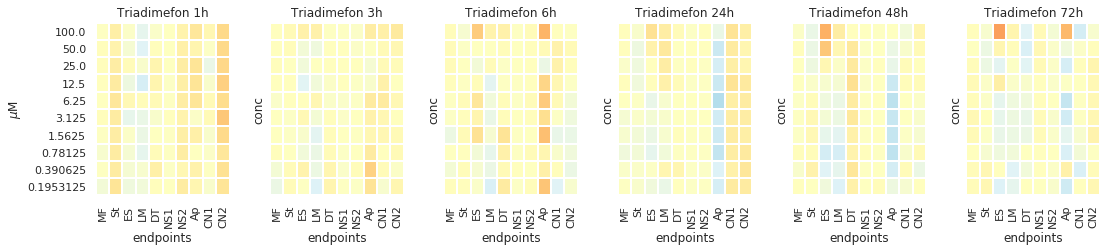

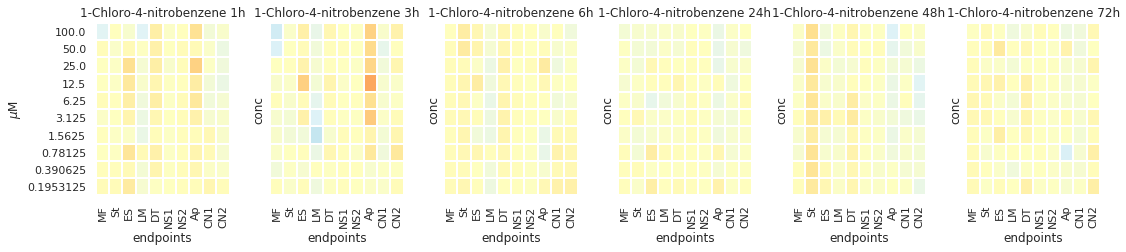

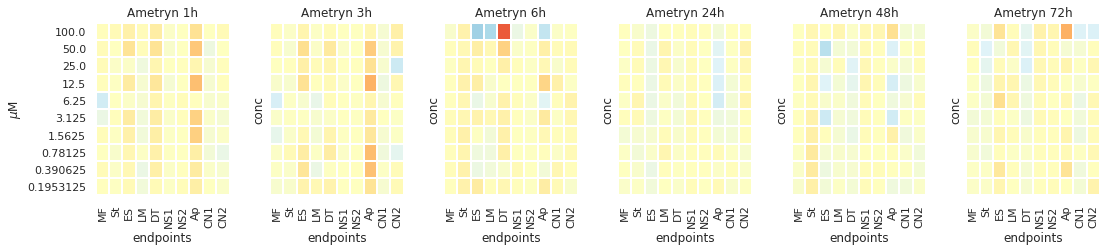

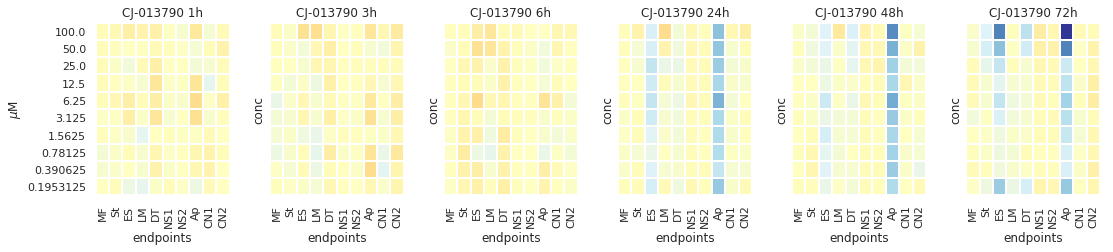

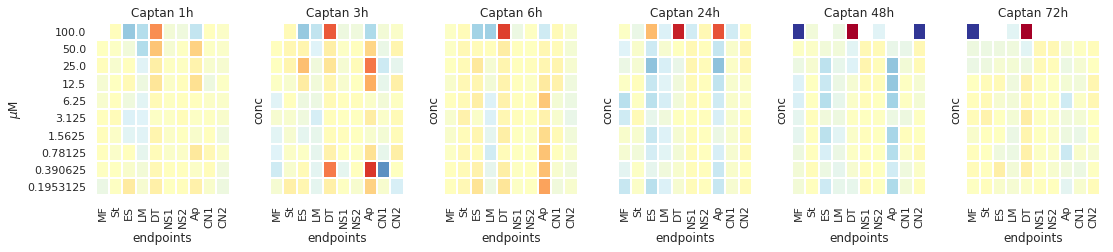

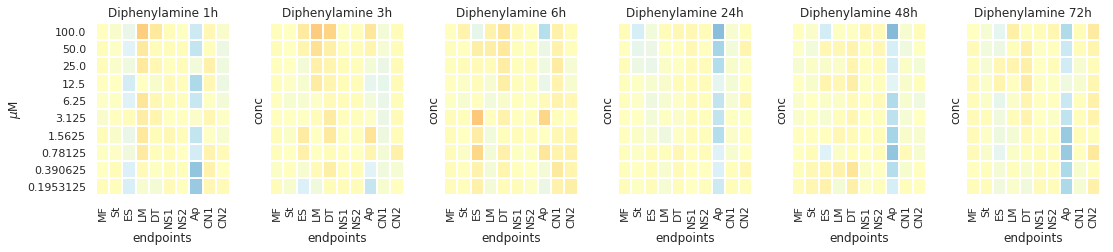

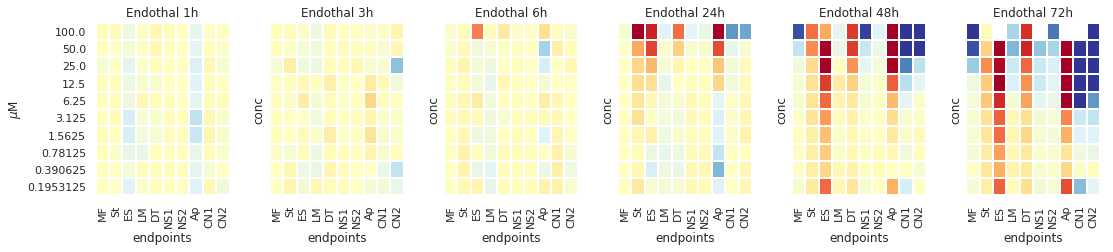

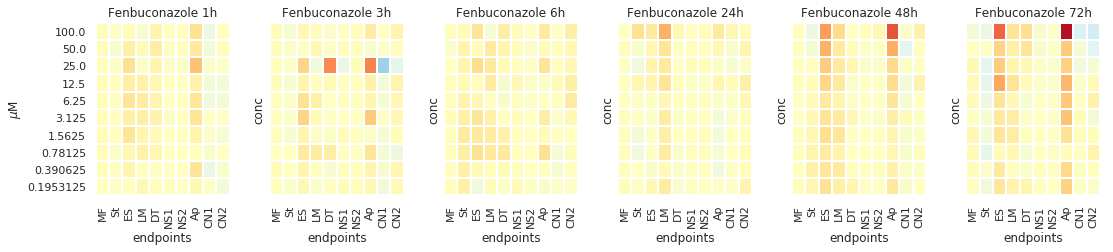

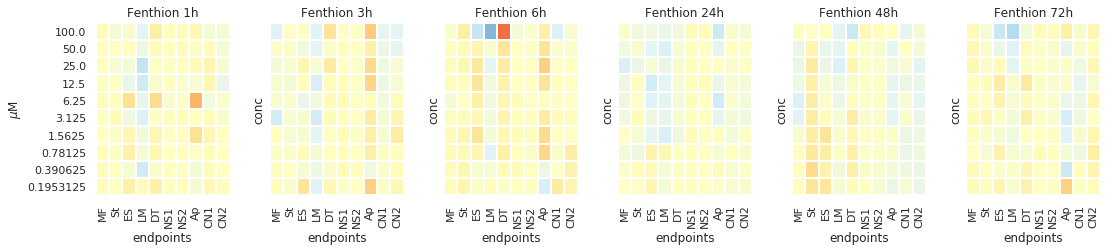

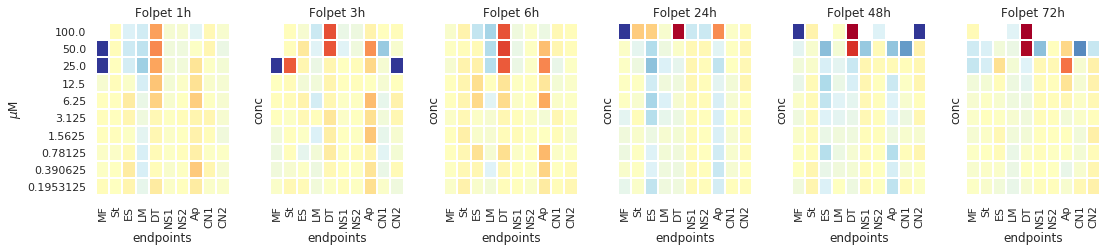

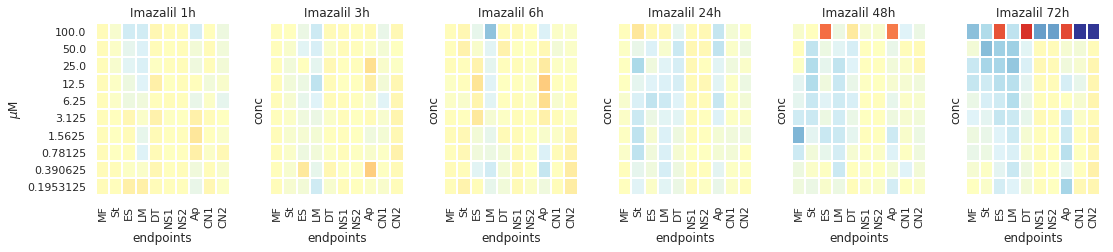

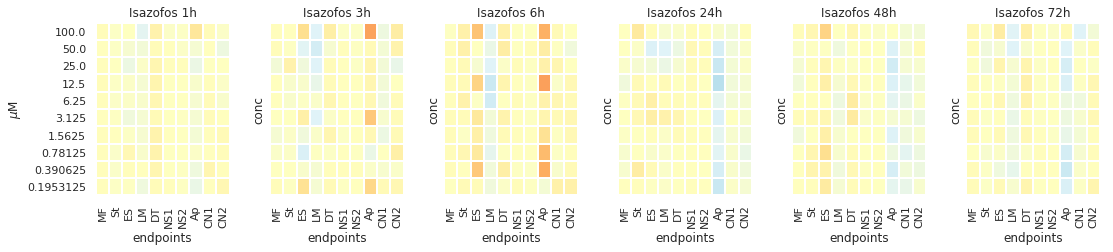

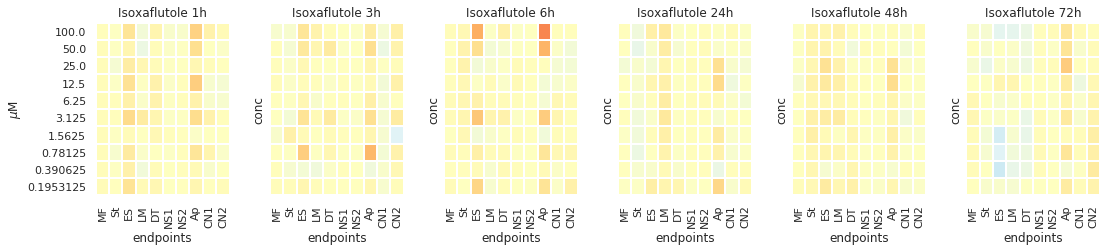

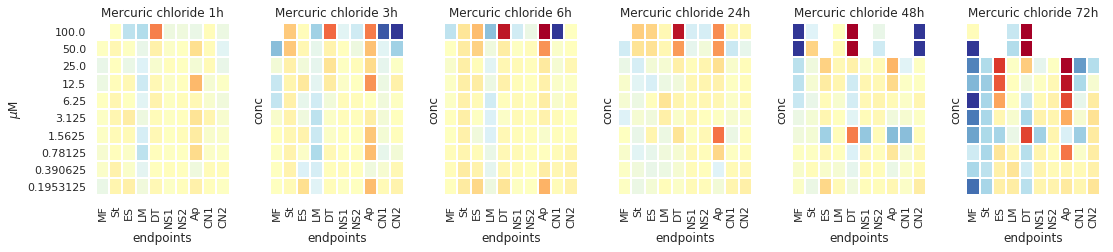

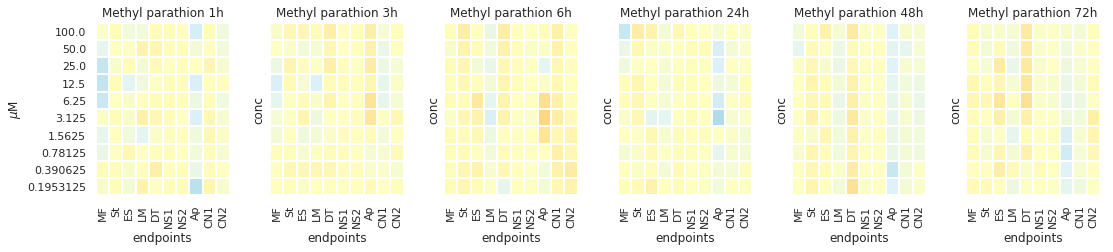

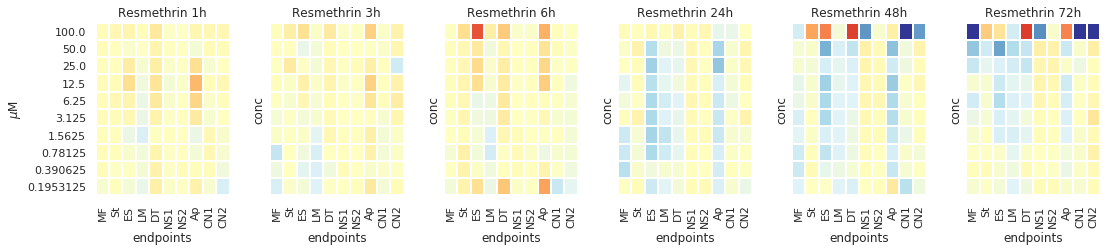

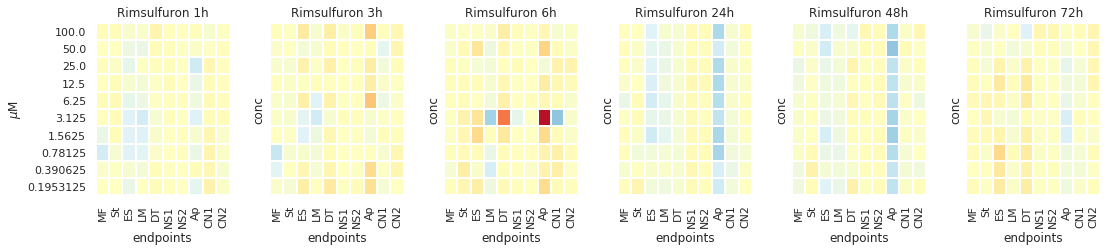

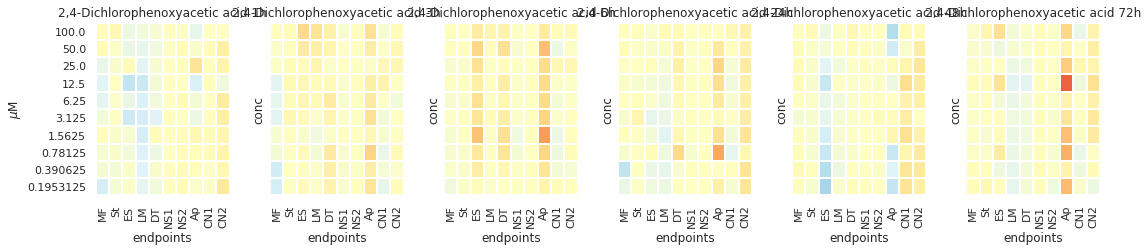

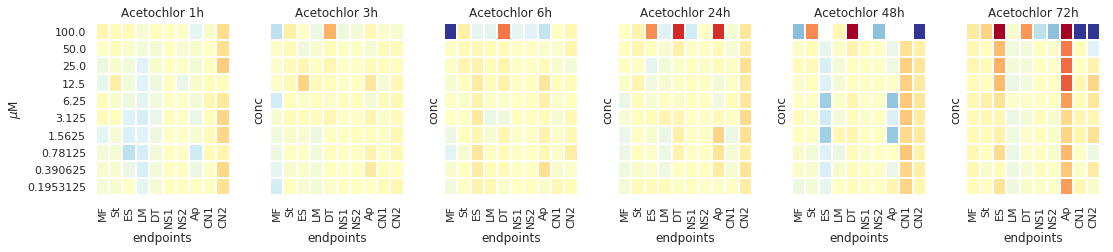

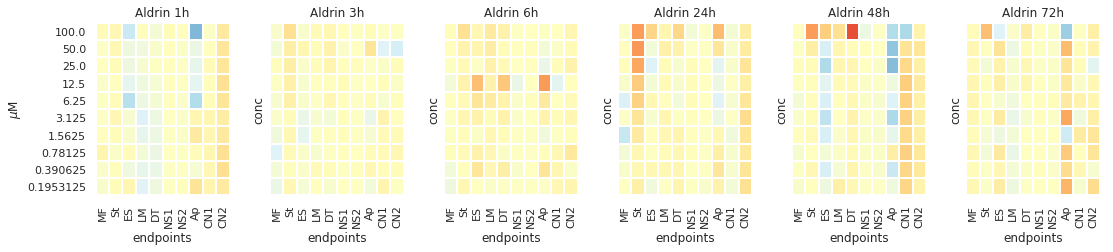

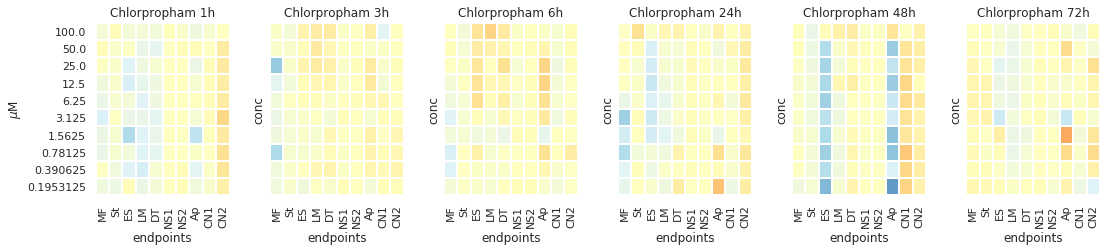

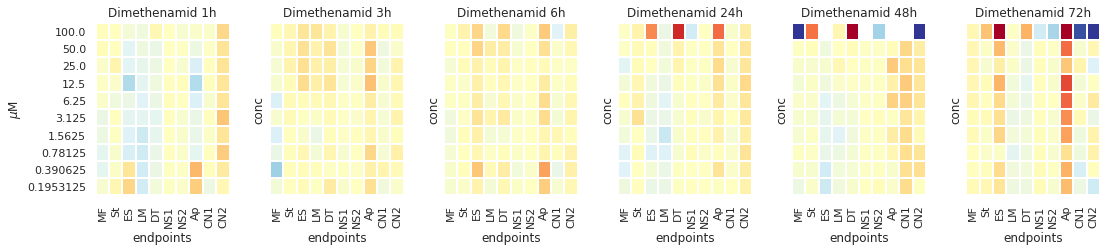

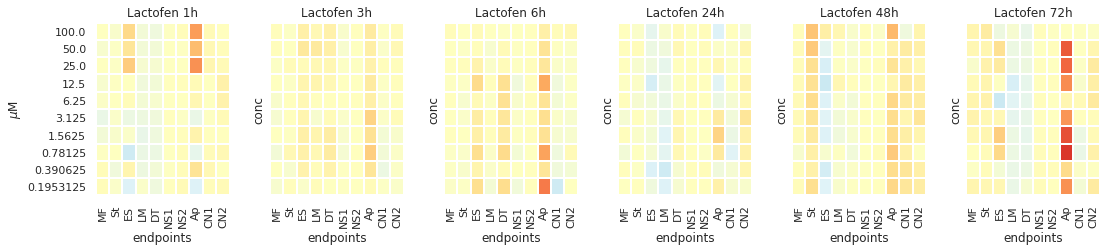

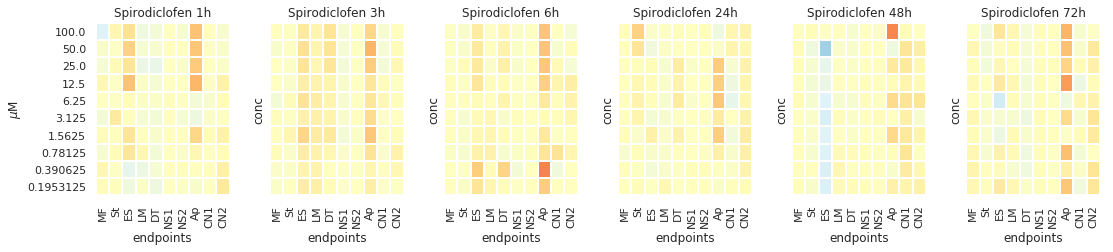

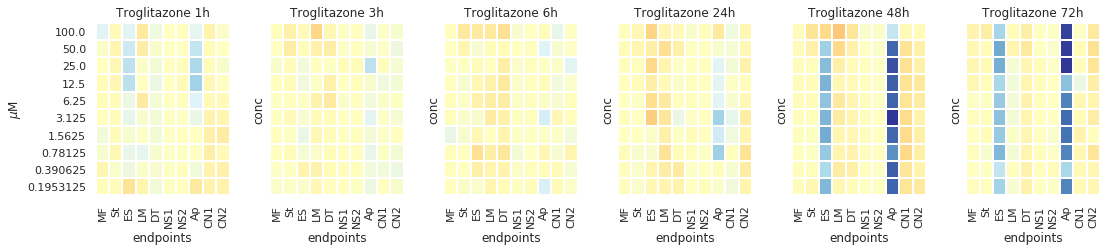

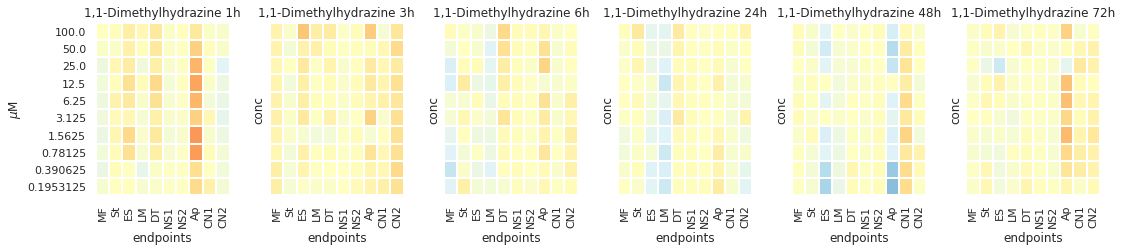

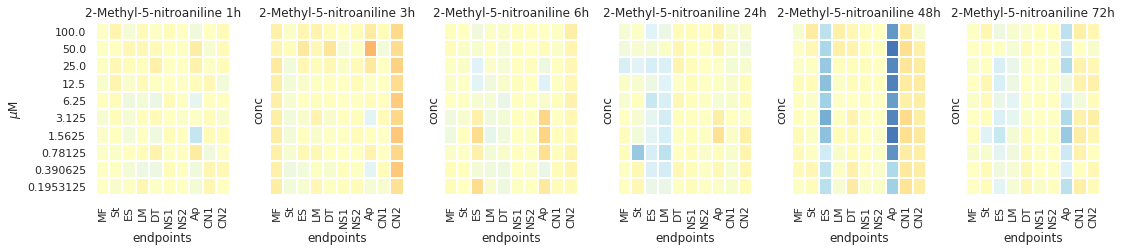

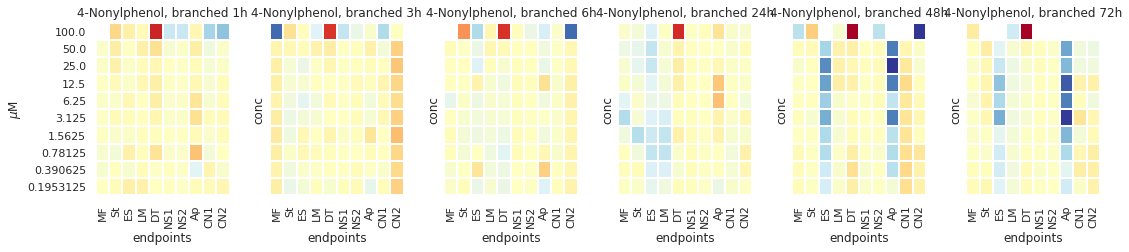

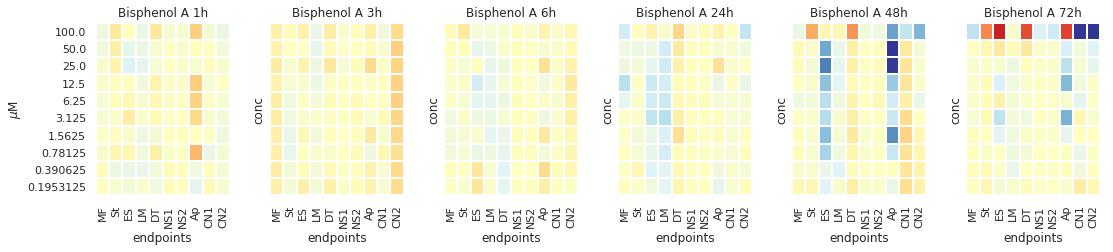

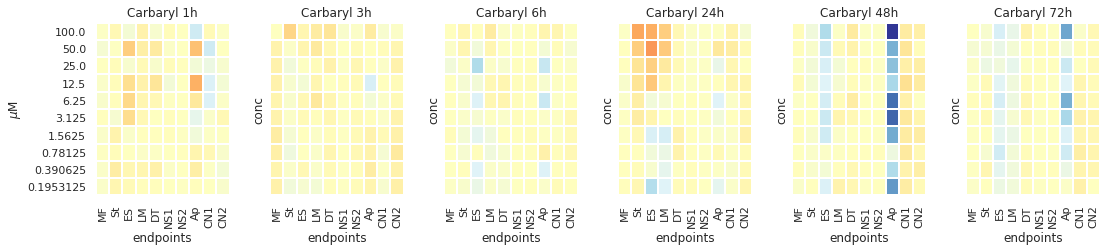

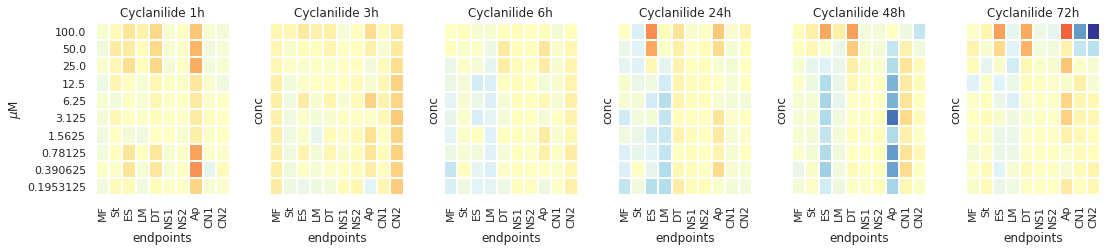

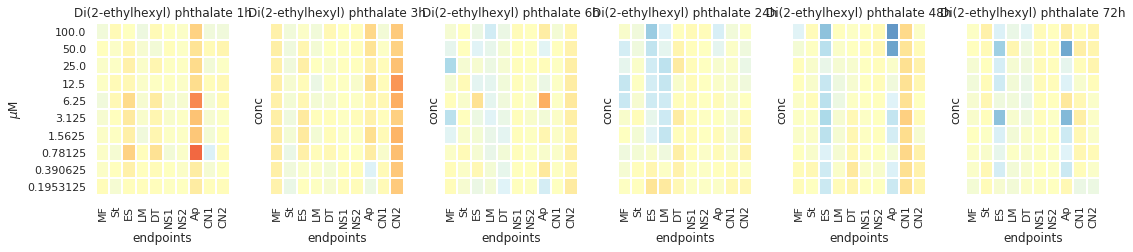

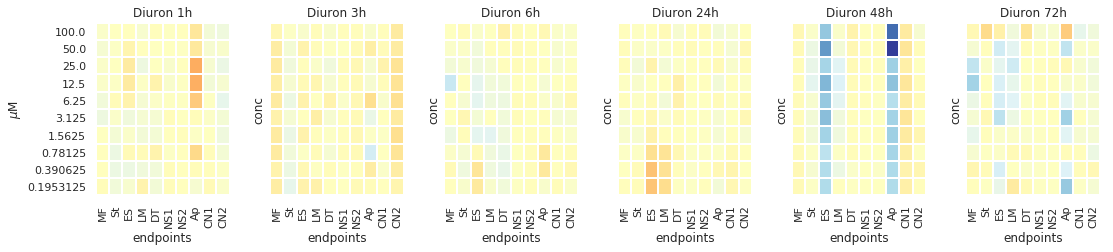

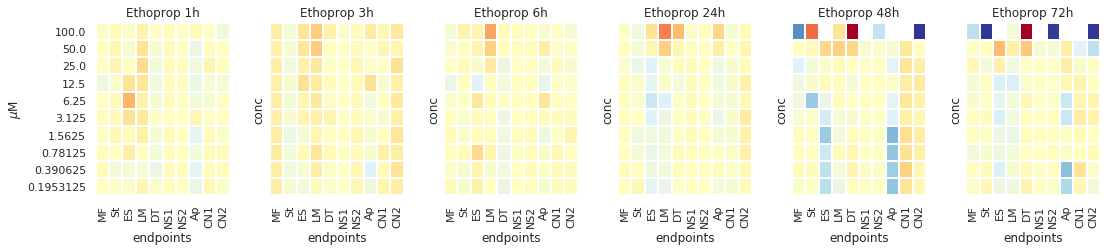

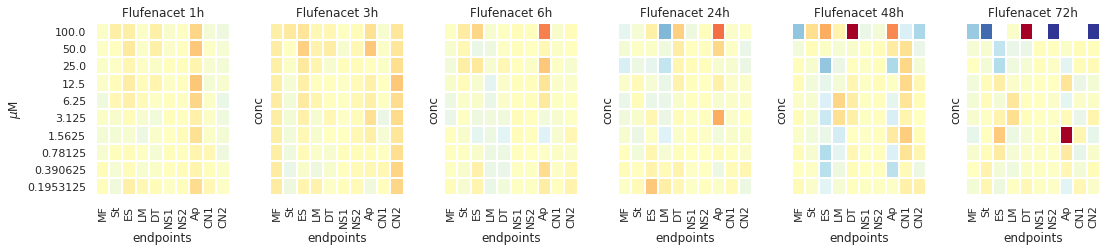

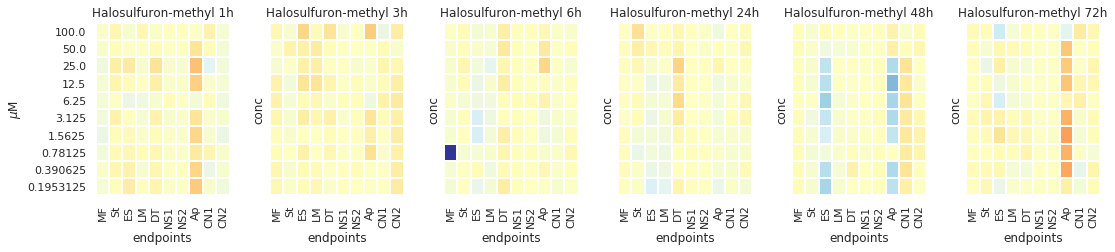

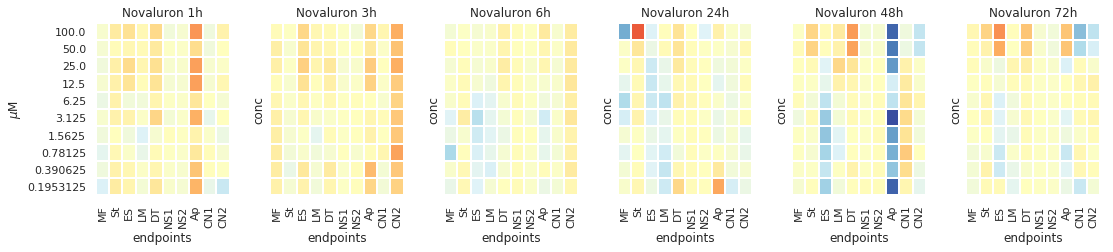

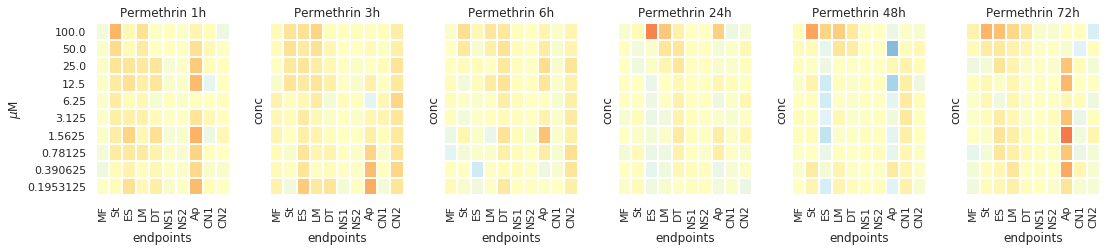

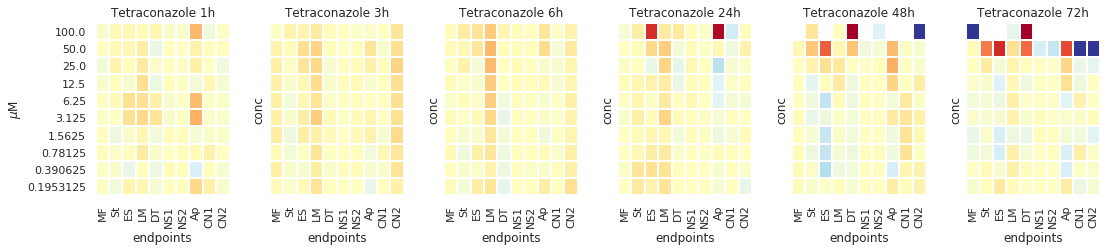

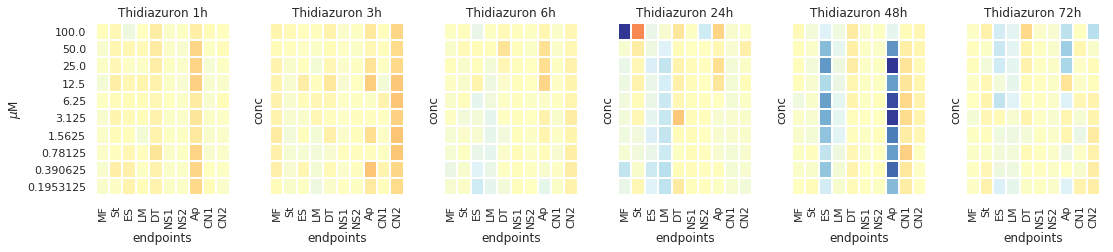

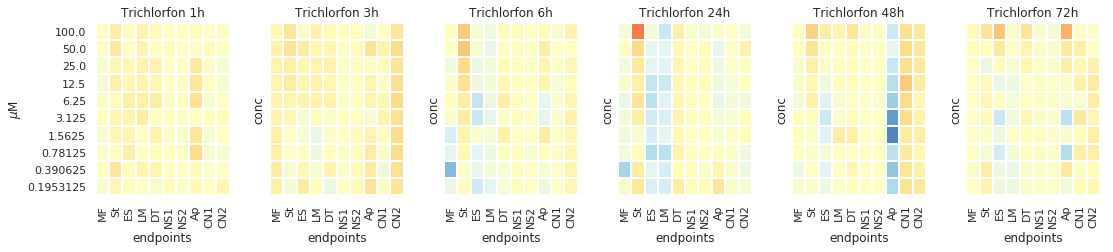

In [14]:
from hci.fc import *
import re
sns.set(style='white')
va ='l2fc_ctrl'
ft  ='FA0'

FDIR=FIG_DIR+'cr'
for chem in HCI.heprn_ch.distinct('chem_ch.name'):
    print chem
    chm = re.sub('[\W]+','-',chem.lower())
    fig = vizChemCR(chem,feat=ft,val=va,pv=None,dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)
    fig.savefig(FDIR+'/'+chm+'.png',bbox_inches='tight')

In [ ]:
HCI.heprn_ch.find_one()